<a href="https://colab.research.google.com/github/gachchami/qmitra/blob/ZNE/ZNE_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq
!pip install mitiq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.7 MB/s eta 0:00:00
INFO: pip is looking at

In [2]:
import cirq
from mitiq import zne, benchmarks


def execute(circuit, noise_level=0.05):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    with depolarizing noise."""
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
    return (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix[0, 0]
        .real
    )


circuit = benchmarks.generate_rb_circuits(n_qubits=1, num_cliffords=50)[0]

true_value = execute(circuit, noise_level=0.0)      # Ideal quantum computer
noisy_value = execute(circuit)                      # Noisy quantum computer
zne_value = zne.execute_with_zne(circuit, execute)  # Noisy quantum computer + Mitiq

print(f"Error w/o  Mitiq: {abs((true_value - noisy_value) / true_value):.3f}")
print(f"Error w Mitiq:    {abs((true_value - zne_value) / true_value):.3f}")

Error w/o  Mitiq: 0.500
Error w Mitiq:    0.499


CODE#2

In [12]:
import cirq

def execute (circuit, noise_level=0.05): #scale noise level from here
  """Returns Tr[rho |0><0|] where rho is state prepared by the circuit with the depolarizing noise."""

  #add depolarising noise
  noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))

  return (
      cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0,0].real

  )

ZNE (we will define a circuit to work with)

In [13]:
a,b,c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.X(c),
    cirq.CNOT(a,b),
    cirq.CNOT(b,c),
    cirq.Y(b),
    cirq.S(a)

)

In [14]:
print(circuit)

0: ───H───@───S───────
          │
1: ───────X───@───Y───
              │
2: ───X───────X───────


In [15]:
from mitiq.zne.scaling import fold_gates_at_random, fold_global

folded_circuit = fold_gates_at_random(circuit, scale_factor = 4) #type of foldings

print(folded_circuit)

0: ───H───H───H───@───@───@───S───S^-1───S───────────────────────────────
                  │   │   │
1: ───────────────X───X───X───@───@──────@───@───@───Y───Y───Y───Y───Y───
                              │   │      │   │   │
2: ───X───X───X───X───X───────X───X──────X───X───X───────────────────────


In [7]:
#Extrapolation (compute the Zero-Noise limit)

In [16]:
from mitiq.zne.inference import RichardsonFactory, LinearFactory, ExpFactory, PolyFactory, PolyExpFactory, AdaExpFactory

factory =  RichardsonFactory([1,3,5]) #here you can change the extrapolation methods: Factory objects

factory.run(circuit, execute)
factory.reduce()



0.024460401386022738

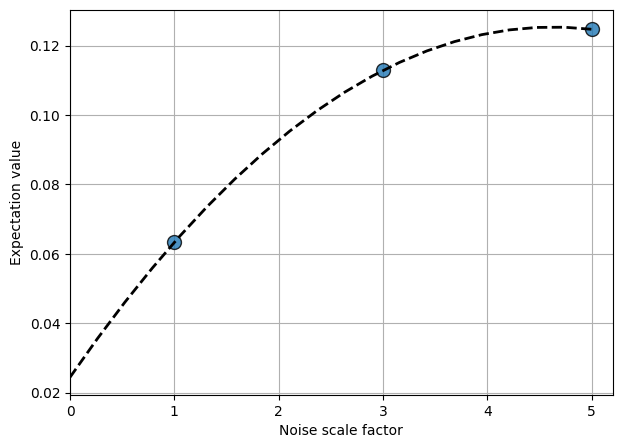

In [17]:
factory.plot_fit();

In [21]:
from mitiq import zne

true_value = execute(circuit,noise_level=0.04)
noisy_value = execute(circuit)
zne_value = zne.execute_with_zne(circuit,execute)

print(f"Error w/o Mitiq:{abs((true_value - noisy_value)/true_value):.3f}")
print(f"Error w Nitiq: {abs((true_value - zne_value)/ true_value):.3f}")

Error w/o Mitiq:0.184
Error w Nitiq: 0.747


In [32]:
"""Returns Tr[rho |0><0|] where rho is state prepared by the circuit with the depolarizing noise."""
# Add depolarizing noise
noisy_circuit = circuit.with_noise(cirq.depolarize(p=0.04))

# Create a DensityMatrixSimulator and simulate the noisy circuit
simulator = cirq.DensityMatrixSimulator()
result = simulator.simulate(noisy_circuit)

# Extract the final density matrix and compute the desired trace
density_matrix = result.final_density_matrix
trace = density_matrix[0, 0]



def some_function():
    trace = density_matrix[0,0]
    return trace

print(trace)


(0.053470325+0j)


In [33]:
print(density_matrix)

[[0.05347032+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.007719j  ]
 [0.        +0.j         0.02618846+0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.00042264j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.04387365+0.j
  0.        +0.j         0.        +0.j         0.        +0.01542643j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.37646717+0.j         0.        +0.28174362j 0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        -0.28174362j 0.37646717+0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        -0.01542643j
  0.        +0.j         0.        +0.j       